### Урок 9. Python применение продвинутых методов
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

Mobile Games AB Testing with Cookie Cats


Набор данных и переменные
У нас есть данные о 90 189 игроках, которые установили игру во время проведения AB-теста.

userid — уникальный номер, идентифицирующий каждого игрока.

version - попал ли игрок в контрольную группу (gate_30 - ворота 30 уровня) или группу с перенесенными воротами (gate_40 - ворота 40 уровня).

sum_gamerounds — количество игровых раундов, сыгранных игроком в течение первых 14 дней после установки.

retention_1 - вернулся ли игрок и играл через 1 день после установки?

retention_7 - вернулся ли игрок и играл через 7 дней после установки?

Когда игрок устанавливал игру, ему или ей случайным образом присваивались gate_30 или gate_40.

In [169]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import bootstrapped.bootstrap as bs
import bootstrapped.compare_functions as bs_compare
import bootstrapped.stats_functions as bs_stats
import statsmodels.stats.power as smp
import math
import numpy as np

df=pd.read_excel('C:/GB/Analyst/AB_test/HW/9/результаты А_B.xlsx')
df

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1
...,...,...,...,...,...
90184,9999441,gate_40,97,1,0
90185,9999479,gate_40,30,0,0
90186,9999710,gate_30,28,1,0
90187,9999768,gate_40,51,1,0


In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  int64 
 4   retention_7     90189 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.4+ MB


In [146]:
df.userid.nunique() #Повторений id нет

90189

In [147]:
#посмотрим выбросы по sum_gamerounds
df.sum_gamerounds.value_counts().sort_index().tail()

2294     1
2438     1
2640     1
2961     1
49854    1
Name: sum_gamerounds, dtype: int64

In [148]:
#уберем выброс 49854 раунда!
df=df[df['sum_gamerounds']<40000]

In [149]:
#Разделим данные на группы, gate 30 и gate 40
gate_30=df[df.version=='gate_30']
gate_30.describe()

,userid,sum_gamerounds,retention_1,retention_7
count,4.469900e+04,44699.000000,44699.000000,44699.000000
mean,4.987532e+06,51.342111,0.448198,0.190183
std,2.881051e+06,102.057598,0.497315,0.392450
min,1.160000e+02,0.000000,0.000000,0.000000
25%,2.505463e+06,5.000000,0.000000,0.000000
50%,4.983630e+06,17.000000,0.000000,0.000000
75%,7.481522e+06,50.000000,1.000000,0.000000
max,9.999710e+06,2961.000000,1.000000,1.000000


In [150]:
gate_40=df[df.version=='gate_40']
gate_40.describe()

,userid,sum_gamerounds,retention_1,retention_7
count,4.548900e+04,45489.000000,45489.000000,45489.000000
mean,5.009073e+06,51.298776,0.442283,0.182000
std,2.885496e+06,103.294416,0.496663,0.385849
min,3.770000e+02,0.000000,0.000000,0.000000
25%,2.517171e+06,5.000000,0.000000,0.000000
50%,5.007329e+06,16.000000,0.000000,0.000000
75%,7.510762e+06,52.000000,1.000000,0.000000
max,9.999861e+06,2640.000000,1.000000,1.000000


<Axes: xlabel='version', ylabel='sum_gamerounds'>

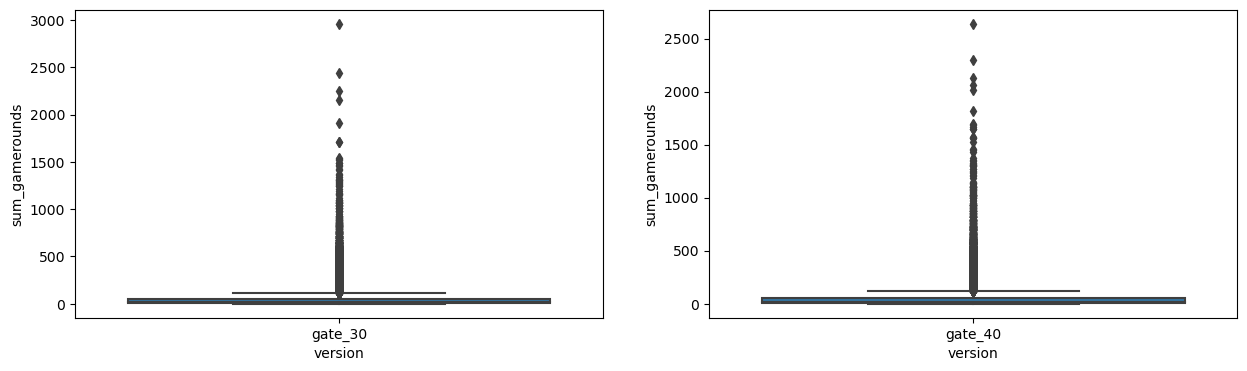

In [151]:
#посмотрим выбросы
fig, (ax_boxplot, bx_boxplot) = plt.subplots(1, 2, figsize=(15,4))
sns.boxplot(x=gate_30['version'], y=gate_30['sum_gamerounds'], ax=ax_boxplot)
sns.boxplot(x=gate_40['version'], y=gate_40['sum_gamerounds'])

На основе полученыых данных можно сказать, что количество людей в группах, средние значения и дисперсия по количеству раундов, количеству вернувшихся пользователей в течение 1 дня и 7 дней имееют одинаковый порядок, соответсвенно их можно анализировать. 

<Axes: xlabel='sum_gamerounds', ylabel='Count'>

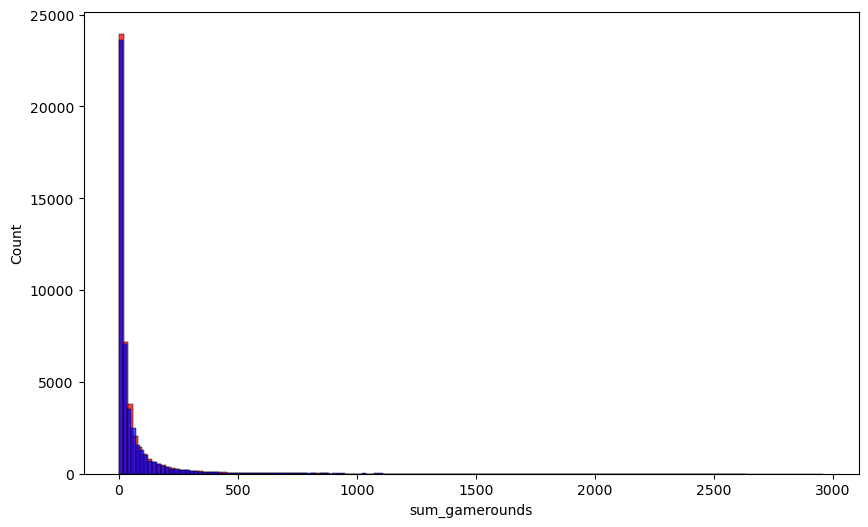

In [152]:
plt.figure(figsize=(10, 6))
sns.histplot(gate_30.sum_gamerounds, color='r', bins=150)
sns.histplot(gate_40.sum_gamerounds, color='b', bins=150)

In [153]:
#По гистограмме видим, что данные распределены ненормально, подтвердим это критериаем Колмогорова-Смирнова:
from scipy.stats import kstest
print(kstest((gate_30['sum_gamerounds']-gate_30['sum_gamerounds'].mean())/gate_30['sum_gamerounds'].std(), 'norm'))
print(kstest((gate_40['sum_gamerounds']-gate_40['sum_gamerounds'].mean())/gate_40['sum_gamerounds'].std(), 'norm'))

KstestResult(statistic=0.3074575469341033, pvalue=0.0, statistic_location=-0.5030699489519455, statistic_sign=-1)
KstestResult(statistic=0.3097261247925254, pvalue=0.0, statistic_location=-0.4966268014004858, statistic_sign=-1)


### Рассмотрим по отдельности все доступные характеристики выборок на наличие статистически значимых различий.
#### 1. Количество сыгранных раундов sum_gamerounds

In [154]:
#Это величина количественная, распределение ненормальное, выборки независимые и их 2 - используем критерий Манна Уитни
from scipy import stats 
stats.mannwhitneyu(gate_30.sum_gamerounds, gate_40.sum_gamerounds)

MannwhitneyuResult(statistic=1024285761.5, pvalue=0.05089155279145376)

In [155]:
#При уровне значимости 0,05 мы не можем сделать вывод, так как pvalue=0.05. Так как выборки имеют примерно одинаковое 
#распределение, используем бутстрап для оценки разницы средних:
result=bs.bootstrap_ab(gate_30.sum_gamerounds.values, gate_40.sum_gamerounds.values, stat_func=bs_stats.mean, 
                       compare_func=bs_compare.difference, alpha=0.05, num_iterations=2000)
print(f'Доверительный интервал разницы средних значений sum_gamerounds в группах: {round(result.lower_bound, 4)}, {round(result.upper_bound, 4)}')

Доверительный интервал разницы средних значений sum_gamerounds в группах: -1.3128, 1.3686


Так как доверительный интервал разницы средних содержит внутри 0, мы может сделать вывод, что с вероятностью 95% статистически значимых различий по количеству сыгранных раундов нет. Количество игроков, установивших игру, но не сышравших ни одрого раунда мы рассматривать не будем, так как эти пользователи не играли по каким то свои причинам, а не по причине разного уровня ворот.

In [156]:
#Посчитаем мощность теста:
mean_30=gate_30.sum_gamerounds.mean()
mean_40=gate_40.sum_gamerounds.mean()
std_30=gate_30.sum_gamerounds.std()
std_40=gate_40.sum_gamerounds.std()
S=((std_30**2+std_40**2)/2)**0.5
n=min(gate_30.shape[0], gate_40.shape[0]) #так как размеры выборок пости одинакове, возьмем минимальный
ef_size=float((mean_30-mean_40)/S)
ef_size, n

(0.00042204843051062347, 44699)

In [157]:
# мы видим, что размер эффекта очень мал, это говорит о том что выборки практически не отличаются. 
# Посчитаем мощность теста 
power=smp.zt_ind_solve_power(effect_size=ef_size, nobs1=n, alpha=0.05, alternative='two-sided')
power

0.05045615182441887

Мощность теста очень мала 5%, она отвечает на вопрос : если нулевая гипотеза в действительности не верна, с какой вероятностью мы сможем отклонить ее в нашем эксперименте (т.е. с нашими параметрами). Такая маленькая мощность логична в следствии очень маленькой разницы средних значений и маленького размера эффекта. Что бы определить такой незначительный эффект как статистически значимый, нужно очень большой размер выборки. Посчитаем его: 

In [158]:
number=smp.zt_ind_solve_power(effect_size=ef_size, alpha=0.05, power=0.80, alternative='two-sided')
number

88127617.10579775

А вот если не убирать выброc в 49854 раундов из группы gate_30, то получим мощность теста уже 14%, а размер выборки тоже значительно меньше, 448589 для каждой из групп.

#### 2.Количество вернувшихся пользователей в течение 1 дня. 
Данные качественные, независимые, групп 2, для определения статистической значимости разницы в группах используем критерий Хи-квадрат.

In [164]:
n_gate30=gate_30.shape[0]
n_gate40=gate_40.shape[0]
m_gate30=gate_30[gate_30.retention_1==1].shape[0]
m_gate40=gate_40[gate_40.retention_1==1].shape[0]
statistic, pvalue, _, _ = stats.chi2_contingency([[m_gate30, n_gate30-m_gate30], [m_gate40, n_gate40-m_gate40]], 
                                                 correction=False)
statistic, pvalue

(3.19373895460949, 0.07392076034183397)

pvalue=0.07, что больше 0,05 и говорит о том, что статистически значимый различий нет между количеством пользователей, вернувшихся в течении 1 дня в обеих группах. Посчитаем мощность теста для этой характеристики через пропорции:

In [172]:
p_gate30=m_gate30/n_gate30
p_gate40=m_gate40/n_gate40
h = 2 * math.asin(np.sqrt(p_gate30)) - 2 * math.asin(np.sqrt(p_gate40))
power=smp.zt_ind_solve_power(effect_size=h, nobs1=n, alpha=0.05, alternative='two-sided')
power

0.42841899148161067

Получаем вероятность отклонить нулевую гипотезу при условии, что верна альтернативная, в данном эксперименте для данной характеристики 43%. Расчитаем нужный объем выборки для мощности 80%:

In [173]:
number=smp.zt_ind_solve_power(effect_size=h, alpha=0.05, power=0.8, alternative='two-sided')
number

110813.40715226658

#### 3. Количество вернувшихся пользователей в течение 7 дней.
Проделываем все тоже самое для этой характеристики.

In [175]:
m_gate30=gate_30[gate_30.retention_7==1].shape[0]
m_gate40=gate_40[gate_40.retention_7==1].shape[0]
statistic, pvalue, _, _ = stats.chi2_contingency([[m_gate30, n_gate30-m_gate30], [m_gate40, n_gate40-m_gate40]], 
                                                 correction=False)
statistic, pvalue

(9.96923845042939, 0.0015917731773992998)

pvalue=0.001, что меньше0,05 и говорит о том, что есть статистически значимые различий между количеством пользователей, вернувшихся в течении 7 дня в обеих группах. Посчитаем мощность теста для этой характеристики через пропорции:

In [183]:
p_gate30=m_gate30/n_gate30
p_gate40=m_gate40/n_gate40
h = 2 * math.asin(np.sqrt(p_gate30)) - 2 * math.asin(np.sqrt(p_gate40))
h

0.021027838248225628

In [177]:
power=smp.zt_ind_solve_power(effect_size=h, nobs1=n, alpha=0.05, alternative='two-sided')
power

0.8817233744262293

Мы видим, что мощность теста достаточная, так же мы видим, что размер эффекта хоть и маленький, но есть. К тому же он положительный, это говорит о том доля retention_7 в группе gate_30 больше, чем доля retention_7 в группе gate_40. 
### Вывод: переносить воторота на уровень gate_40 смысла нет, так как по характеристикам sum_gamerounds и retention_1 статистически значимых различий не обнаружено, а по retention_7 группа с уровнем gate_30 показала больший возврат.